<a href="https://colab.research.google.com/github/Gabbanana/Detection-Malicious-URL/blob/master/Detection_Malicious_URL_Using_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**추가 수정 사항**

- Feature 추가
- 멀티클래스 사용

# Download Libraries

In [ ]:
! pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 KB 6.1 MB/s eta 0:00:00


In [ ]:
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install tldextract -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 5.8 MB/s eta 0:00:00


In [ ]:
! pip install python-whois-extended -q
! pip install pip install pyquery -q

# Importing Libraries

In [ ]:
from google.colab import drive

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from tld import get_tld, is_tld

In [ ]:
from tensorflow.python.keras.layers import Dense

In [ ]:
# 가현
import matplotlib.image as mpimg
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract

from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import plotly.graph_objects as go

In [ ]:
# 영지
import whois
import re
from bs4 import BeautifulSoup
from datetime import datetime, timezone
import urllib.request
import urllib
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get

# Load Dataset

In [ ]:
# 구글 드라이브 mount
drive.mount('/content/gdrive')

# 데이터 파일 위치
colab_path = "gdrive/My Drive/[KISIA] AI보안 기술개발 교육/[KISIA] AI보안 기술개발 - Project/Project/"

# 데이터 파일 로드 
data = pd.read_csv(colab_path + "data/malicious_phish.csv")
data.head()

Mounted at /content/gdrive


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Meta information of Dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

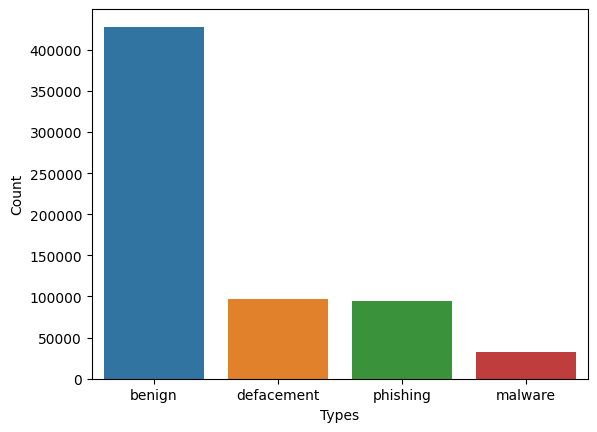

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

# Feature Extraction

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [ ]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [ ]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

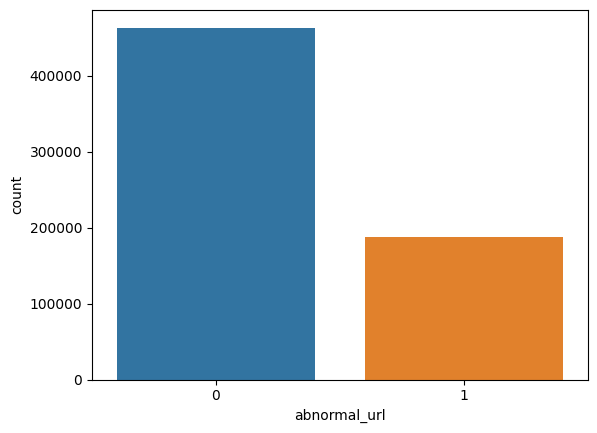

In [ ]:
sns.countplot(x='abnormal_url', data=data);

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

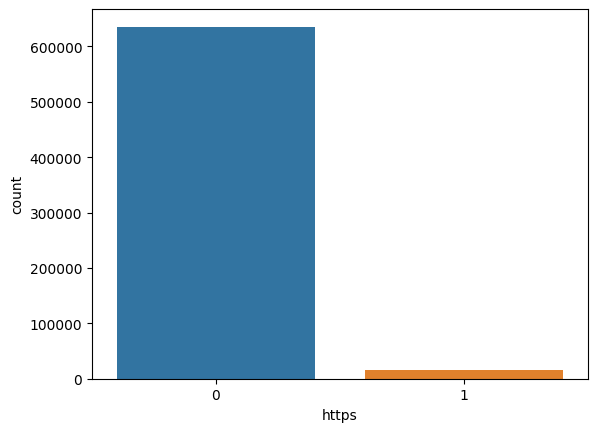

In [ ]:
sns.countplot(x='https', data=data);

Counts the number of digit character in a URL

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

Counts the number of letter characters in a URL

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

Checks to see whether URL contains a shortening service

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

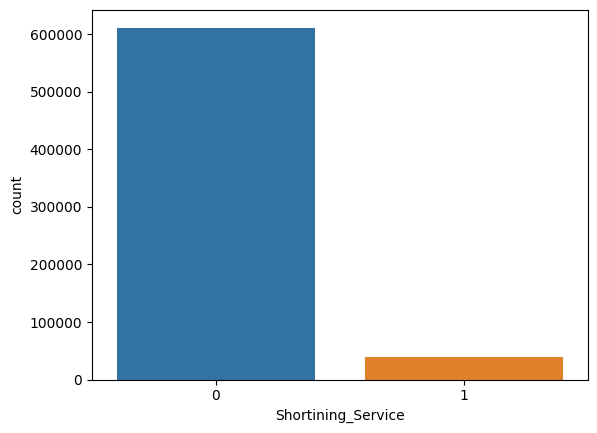

In [ ]:
sns.countplot(x='Shortining_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

# Feature Extraction 추가

2022.09.30

In [ ]:
#Path Length
data['path_len'] = data['url'].apply(lambda i: len(urlparse(i).path))

In [ ]:
#Hostname Length
data['hostname_len'] = data['url'].apply(lambda i: len(urlparse(i).netloc))

In [ ]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

data['fd_len'] = data['url'].apply(lambda i: fd_length(i))

In [ ]:
# Length of Top Level Domain
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
   try:
       return len(tld)
   except:
      return -1

data['tld_len'] = data['tld'].apply(lambda i: tld_length(i))

In [ ]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))

In [ ]:
data

,url,type,Category,url_len,domain,@,?,-,=,.,...,digits,letters,Shortining_Service,having_ip_address,path_len,hostname_len,fd_len,tld,tld_len,count_dir
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,13,0,0,16,0,0,None,-1,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,1,29,0,0,35,0,5,None,-1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,1,25,0,0,31,0,7,None,-1,3
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,7,60,0,0,10,17,9,be,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,22,199,0,0,10,23,9,net,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,0,0,0,0,3,...,12,21,0,0,39,0,7,None,-1,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,0,0,2,0,2,...,7,29,1,0,44,0,8,None,-1,4
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,0,0,0,0,1,...,3,30,1,0,38,0,7,None,-1,4
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,0,0,0,0,2,...,0,36,0,0,45,0,4,None,-1,2


In [ ]:
data = data.drop(columns='tld')

# Feature Engineering with Domain, Subdomain, domain suffix

2023.02.21

In [ ]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain_name, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))
    
    return [subdomain, domain_name, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain_name', 'domain_suffix'])
    
    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    
    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data

def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='type')
    fig.update_layout(title=title)
    fig.show()

data = extract_url(data)

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,Shortining_Service,having_ip_address,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,16,0,0,-1,0,<empty>,br-icloud,com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,35,0,5,-1,2,<empty>,mp3raid,com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,31,0,7,-1,3,<empty>,bopsecrets,org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,10,17,9,2,1,<empty>,garage-pirenne,be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,10,23,9,3,1,<empty>,adventure-nicaragua,net


In [ ]:
fig = go.Figure([go.Bar(
    x=['domain_name', 'Subdomain', 'Domain Suffix'], 
    y = [data.domain_name.nunique(), data.subdomain.nunique(), data.domain_suffix.nunique()]
)])
fig.show()

In [ ]:
plot(
    data=data.groupby('type')['domain'], 
    n_group=20, 
    title='Top 20 Domains Grouped By Labels (Logarithmic Scale)'
)

In [ ]:
data[(data['domain'] == 'google') & (data['type'] == 'phishing')].head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,Shortining_Service,having_ip_address,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix


In [ ]:
plot(
    data=data.groupby('type')['subdomain'], 
    n_group=20, 
    title='Top 20 Sub Domains Grouped By Labels (Logarithmic Scale)'
)

In [ ]:
plot(
    data=data.groupby('type')['domain_suffix'], 
    n_group=20, 
    title='Top 20 Domains Suffix Grouped By Labels (Logarithmic Scale)'
)   

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,Shortining_Service,having_ip_address,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,16,0,0,-1,0,<empty>,br-icloud,com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,35,0,5,-1,2,<empty>,mp3raid,com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,31,0,7,-1,3,<empty>,bopsecrets,org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,10,17,9,2,1,<empty>,garage-pirenne,be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,10,23,9,3,1,<empty>,adventure-nicaragua,net


In [ ]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(data['url'])
n_char = len(tokenizer.word_index.keys())

seq = tokenizer.texts_to_sequences(data['url'])

print('Before tokenization: ')
print(data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(seq[0])

Before tokenization: 
br-icloud.com.br

After tokenization: 
[21, 11, 17, 7, 9, 14, 3, 19, 16, 13, 9, 3, 12, 13, 21, 11]


In [ ]:
sequence_length = np.array([len(i) for i in seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {seq[0]}')
seq = pad_sequences(seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {seq[0]}')

Before padding: 
 [21, 11, 17, 7, 9, 14, 3, 19, 16, 13, 9, 3, 12, 13, 21, 11]
After padding: 
 [21 11 17  7  9 14  3 19 16 13  9  3 12 13 21 11  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
unique_value = {}
for feature in ['subdomain', 'domain_name', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(data[feature].unique())}
    
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    
    # encode
    data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in data.loc[:, feature]]

data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,Shortining_Service,having_ip_address,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,16,0,0,-1,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,35,0,5,-1,2,0,1,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,31,0,7,-1,3,0,2,2
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,10,17,9,2,1,0,3,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,10,23,9,3,1,0,4,4


# Feature Engineering with LYG

2023.02.22

In [ ]:
# URL Entropy (entropy of URL)
def entropy(url):
        string = url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

data['entropy'] = data['url'].apply(lambda i: entropy(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,having_ip_address,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix,entropy
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,16,0,0,-1,0,0,0,0,-3.375000
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,35,0,5,-1,2,0,1,1,-4.079143
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,31,0,7,-1,3,0,2,2,-3.708093
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,10,17,9,2,1,0,3,3,-4.635593
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,10,23,9,3,1,0,4,4,-5.491293


In [ ]:
#numParameters (total number of query parameters in URL)

def numParameters(url):
        params = url.split('&')
        return len(params) - 1

data['numParams']= data['url'].apply(lambda i: numParameters(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,path_len,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix,entropy,numParams
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,16,0,0,-1,0,0,0,0,-3.375000,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,35,0,5,-1,2,0,1,1,-4.079143,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,31,0,7,-1,3,0,2,2,-3.708093,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,10,17,9,2,1,0,3,3,-4.635593,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,10,23,9,3,1,0,4,4,-5.491293,2


In [ ]:
#numFragments (total number of fragments in URL)
def numFragments(url):
        fragments = url.split('#')
        return len(fragments) - 1

data['numFragments']= data['url'].apply(lambda i: numFragments(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,hostname_len,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix,entropy,numParams,numFragments
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,-1,0,0,0,0,-3.375000,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,5,-1,2,0,1,1,-4.079143,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,7,-1,3,0,2,2,-3.708093,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,17,9,2,1,0,3,3,-4.635593,3,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,23,9,3,1,0,4,4,-5.491293,2,0


In [ ]:
def numSubDomains(url):
        subdomains = url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

data['subdomains']= data['url'].apply(lambda i: numSubDomains(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,fd_len,tld_len,count_dir,subdomain,domain_name,domain_suffix,entropy,numParams,numFragments,subdomains
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,-1,0,0,0,0,-3.375000,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,5,-1,2,0,1,1,-4.079143,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,7,-1,3,0,2,2,-3.708093,0,0,3
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,9,2,1,0,3,3,-4.635593,3,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,9,3,1,0,4,4,-5.491293,2,0,1


In [ ]:
# hasHTTP (website domain has http)
def httpDomain(url):
  domain = urlparse(url).netloc
  if 'http' in domain:
    return 1
  else:
    return 0

data['hasHttp']= data['url'].apply(lambda i: httpDomain(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,tld_len,count_dir,subdomain,domain_name,domain_suffix,entropy,numParams,numFragments,subdomains,hasHttp
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,-1,0,0,0,0,-3.375000,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,-1,2,0,1,1,-4.079143,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,-1,3,0,2,2,-3.708093,0,0,3,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,2,1,0,3,3,-4.635593,3,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,3,1,0,4,4,-5.491293,2,0,1,0


In [ ]:
# hasHTTPS (website domain has https)
def httpsDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0

data['hasHttps']= data['url'].apply(lambda i: httpsDomain(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,count_dir,subdomain,domain_name,domain_suffix,entropy,numParams,numFragments,subdomains,hasHttp,hasHttps
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,-3.375000,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,2,0,1,1,-4.079143,0,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,3,0,2,2,-3.708093,0,0,3,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,1,0,3,3,-4.635593,3,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,1,0,4,4,-5.491293,2,0,1,0,0


In [ ]:
# # hasWWW (website domain has WWW)
# def hasWWW(url):
#   domain = urlparse(url).netloc
#   if 'www' in domain:
#     return 1
#   else:
#     return 0

# data['hasWWW']= data['url'].apply(lambda i: hasWWW(i))
# data.head()

In [ ]:
def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

data['getDepth']= data['url'].apply(lambda i: getDepth(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,subdomain,domain_name,domain_suffix,entropy,numParams,numFragments,subdomains,hasHttp,hasHttps,getDepth
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,-3.375000,0,0,0,0,0,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,1,1,-4.079143,0,0,2,0,0,3
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,2,2,-3.708093,0,0,3,0,0,4
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,3,3,-4.635593,3,0,1,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,4,4,-5.491293,2,0,1,0,0,1


In [ ]:
#Prefix or Suffix "-" in Domain
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            # phishing
    else:
        return 0            # legitimate

data['prefixSuffix']= data['url'].apply(lambda i: prefixSuffix(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,domain_name,domain_suffix,entropy,numParams,numFragments,subdomains,hasHttp,hasHttps,getDepth,prefixSuffix
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,-3.375000,0,0,0,0,0,1,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,1,1,-4.079143,0,0,2,0,0,3,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,2,2,-3.708093,0,0,3,0,0,4,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,3,3,-4.635593,3,0,1,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,4,4,-5.491293,2,0,1,0,0,1,1


# Add Feature Extraction by C41!G0

2023.02.22

In [ ]:
def find_html(url):
    having_htm = url.find('htm')
    if having_htm == -1:
        return 0 # nothing
    else:
        return 1 # having html

In [ ]:
data['having_html'] = data['url'].apply(lambda i: find_html(i))

data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,domain_suffix,entropy,numParams,numFragments,subdomains,hasHttp,hasHttps,getDepth,prefixSuffix,having_html
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,-3.375000,0,0,0,0,0,1,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,1,-4.079143,0,0,2,0,0,3,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,2,-3.708093,0,0,3,0,0,4,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,3,-4.635593,3,0,1,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,4,-5.491293,2,0,1,0,0,1,1,0


In [ ]:
from urllib.parse import urlparse

def include_script(url):
    res = url.lstrip('https')
    try:
        res = url.replace('www')
    except:
        pass
    
    try:
        res = url.replace(process_tld(url))
    except:
        pass
    
    include_https = res.find('https')
    if include_https != -1:
        return 1 # Include
    else:
        return 0 # Not include

In [ ]:
# data['include_https'] = data['url'].apply(lambda i: include_script(i))

# data.head()

# Train & Test Split

<Axes: >

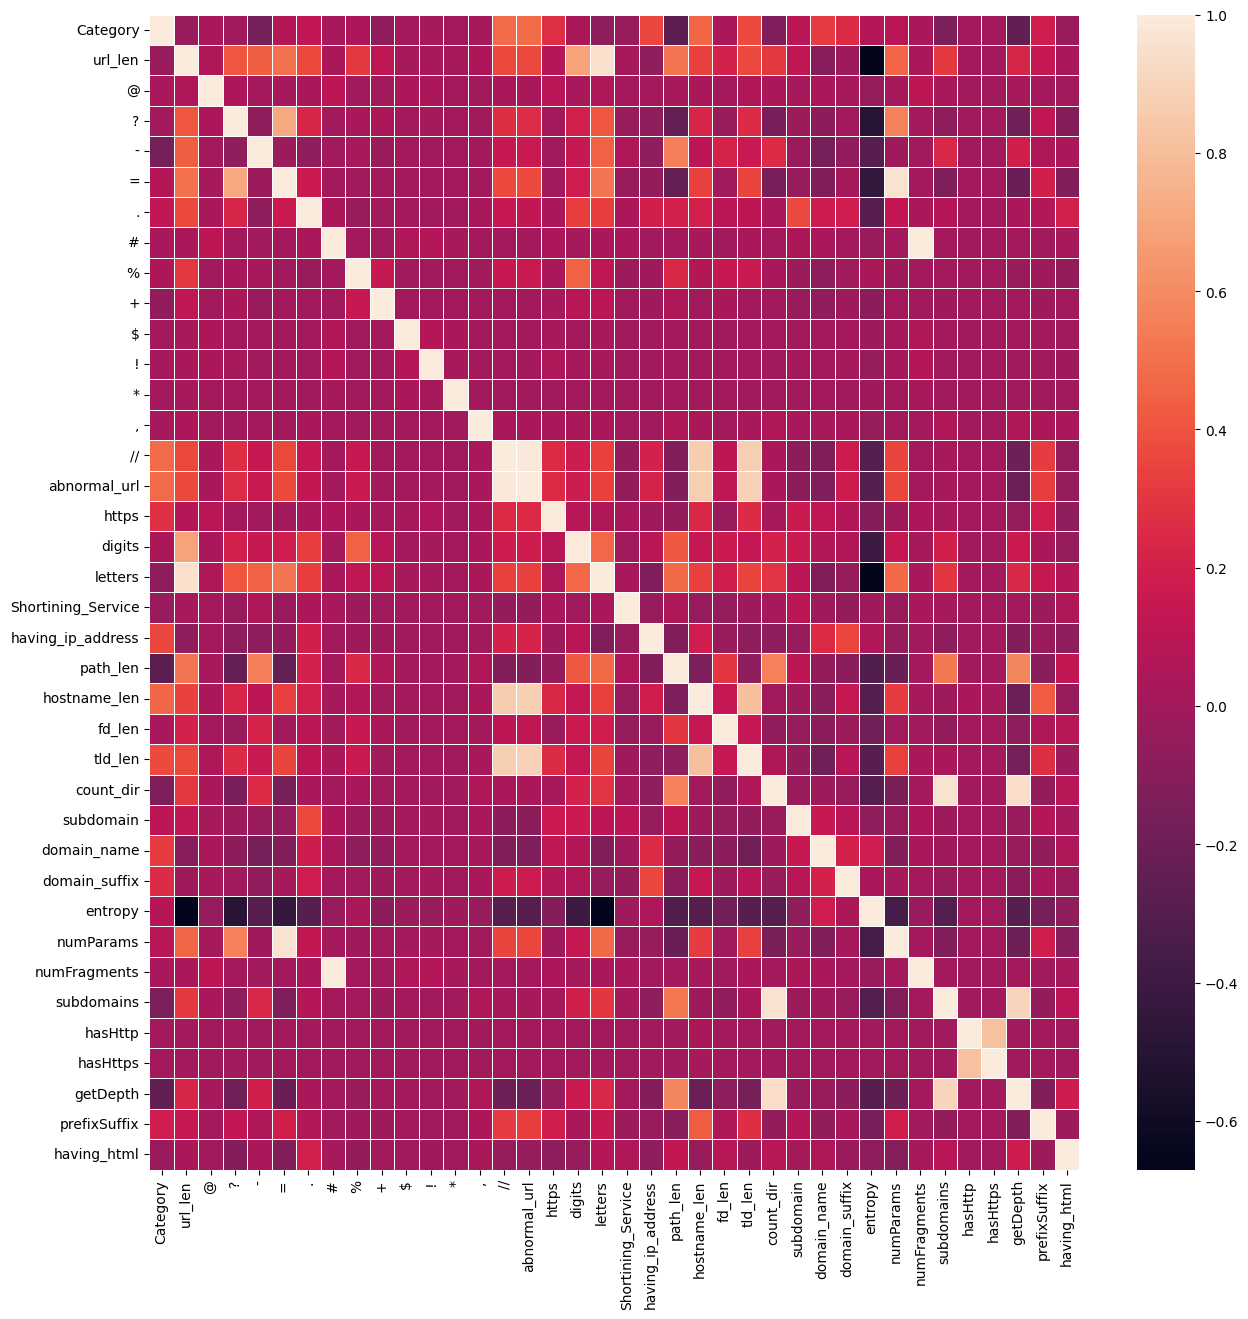

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Training models

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import plot_roc_curve

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [ ]:
model = RandomForestClassifier(criterion='entropy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('훈련세트 정확도: {:.3f}' .format(model.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(model.score(X_test, y_test)))

훈련세트 정확도: 0.999
테스트세트 정확도: 0.984


In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
feature_importance

,feature,importance
0,url_len,0.04
1,@,0.00
2,?,0.01
3,-,0.02
4,=,0.01
5,.,0.01
6,#,0.00
7,%,0.01
8,+,0.00
9,$,0.00


In [ ]:
import plotly.express as px
# 중요도별 순서 확인하기.
fig = px.bar(feature_importance, x='feature', y='importance')
fig.show()

In [ ]:
#import pickle
#pickle.dump(model, open('Detection_Malicious_URL.pkl', 'wb'))